In [1]:
import numpy as np
import os, glob
import gdal, osr # python2.7 - installed in?
import matplotlib
from matplotlib import pyplot as plt
import PIL
from PIL import Image
from datetime import datetime
import matplotlib.cm as cm
import matplotlib as mpl

In [2]:
now = datetime.now()
print(now)

2020-11-25 16:32:41.428440


In [3]:
matplotlib.__version__

'2.2.5'

In [4]:
gdal.VersionInfo()

'3010400'

## manually set the date to label the plot

In [5]:
plot_date = "1 April 2013"
print(plot_date)

saved_img_name = 'oneBlock_1Apr2013.jpg'
# saved_img_name = 'test_4.jpg'

print(saved_img_name)

1 April 2013
oneBlock_1Apr2013.jpg


## set directory path to mosaic file 

In [6]:
#~ float dtype
raster_fullpath = '/Volumes/Ehsan7757420250/2013/roughness_2013_apr1to16_p1to233_b1to40/roughness_subdir_2013_4_1/rasters_noDataNeg99_TiffFileFloat64_max/raster_path_212_block_39_85GCPs_noGdalRes_dTypeFloat64_85gcps_reprojToEPSG_3995.tif'

# raster_fullpath = '/Users/ehsanmos/Documents/RnD/MISR_lab/roughness_dir.nosync/test_p75_180_srcNoData99_dstNodata99_tiffFileFloat64_max/rasters/raster_path_180_block_30_85GCPs_noGdalRes_dTypeFloat64_85gcps_reprojToEPSG_3995.tif'

print(raster_fullpath)


/Volumes/Ehsan7757420250/2013/roughness_2013_apr1to16_p1to233_b1to40/roughness_subdir_2013_4_1/rasters_noDataNeg99_TiffFileFloat64_max/raster_path_212_block_39_85GCPs_noGdalRes_dTypeFloat64_85gcps_reprojToEPSG_3995.tif


In [7]:
#~ check if ratster exist
if (os.path.isfile(raster_fullpath)):
    print('-> raster found!')
else:
    print('-> raster NOT exist!')
    

-> raster found!


In [8]:
#~ raster2array: read data from raster in to array
dataset = gdal.Open(raster_fullpath)
print('-> dataset type: %s' %type(dataset))


-> dataset type: <class 'osgeo.gdal.Dataset'>


In [9]:
raster = dataset.GetRasterBand(1)

## build a dictionary to fill w/ metadata

In [10]:
metadata = {}
print(type(metadata))

<type 'dict'>


## we create metadata

In [11]:
metadata['array_rows'] = dataset.RasterYSize
metadata['array_cols'] = dataset.RasterXSize

print('rows: %s' % metadata['array_rows'])
print('columns: %s' % metadata['array_cols'])

rows: 1449
columns: 2318


## geoTransform info

In [12]:
geotransform = dataset.GetGeoTransform()
print(geotransform) # note: units in meters
print('order of geoTransform matrix= tlX, pixelW, 0, tlY, 0, pixelH')

(-775900.9616607283, 273.8466830174553, 0.0, -2668854.4375756206, 0.0, -273.8466830174553)
order of geoTransform matrix= tlX, pixelW, 0, tlY, 0, pixelH


In [13]:
xMin = geotransform[0]
xMax = geotransform[0] + dataset.RasterXSize*geotransform[1]        # i changed it to * to get xMax value
yMin = geotransform[3] + dataset.RasterYSize*geotransform[5]
yMax = geotransform[3]

In [14]:
print(xMin)
print(xMax)
print(yMin)
print(yMax)

-775900.961661
-141124.350426
-3065658.28127
-2668854.43758


In [15]:
# metadata['extent'] = (xMin,xMax,yMin,yMax)
plot_extent = (xMin,xMax,yMin,yMax)
plot_extent

(-775900.9616607283,
 -141124.35042626702,
 -3065658.281267913,
 -2668854.4375756206)

## get shape of roughness data

In [16]:
# array_shape = raster.ReadAsArray(0,0, metadata['array_cols'], metadata['array_rows']).astype('byte').shape # check this f(.)
array_shape = raster.ReadAsArray(0,0, metadata['array_cols'], metadata['array_rows']).astype('float64').shape # check this f(.)

print(array_shape)

(1449, 2318)


## build an array with zeros

In [17]:
# rough_arr = np.zeros((array_shape[0], array_shape[1], dataset.RasterCount), dtype='byte') # check f(.) arguments
rough_arr = np.zeros((array_shape[0], array_shape[1], dataset.RasterCount), dtype='float64') # check f(.) arguments

In [18]:
print(rough_arr.dtype)
print(rough_arr.min())
print(rough_arr.max())

float64
0.0
0.0


## read roughess data inside array and fill zero array with it

In [19]:
# rough_arr = raster.ReadAsArray(0, 0, metadata['array_cols'], metadata['array_rows']).astype('byte')
rough_arr = raster.ReadAsArray(0, 0, metadata['array_cols'], metadata['array_rows']).astype('float64')

In [20]:
# print(type(rough_arr))
print(rough_arr.dtype)

print('-> array shape: (%s, %s)' % rough_arr.shape)
print('-> roughness min: %s' % rough_arr.min())
print('-> roughness max: %s' % rough_arr.max())

float64
-> array shape: (1449, 2318)
-> roughness min: -999994.0
-> roughness max: 829.2362670898438


## >>> plot section ...

In [21]:
print('-> making plot...')

-> making plot...


## using PIL library

In [22]:
# # create PIL image from roughness array
# rough_PIL_img = Image.fromarray(roughness_array)
# print(type(rough_PIL_img))
# # rough_PIL_img.show()

## test if we can mask negative pixels

In [23]:
# # mask_cond = (rough_arr >= 0.0) & (rough_arr == -999994.0)  # elementwize and; returns boolean mask 
# # print(mask_cond)

# #~ test2 w/np.where 
# np.where((rough_arr >= 0.0) & (rough_arr == -999994.0), np.NAN, rough_arr)

# # rough_arr[mask_cond] = np.nan # nan rough values and land mask pixels 
# plt.imshow(rough_arr, cmap='gray') # plot the rest of data



## >>> build mask arrays (Q- how to mask array? and overlay/plot both over each other?)

In [24]:
#~ 1st, update -99 --> Nan 
# rough_arr[rough_arr == -99.0] = np.nan

## 1-filter for roughness

In [25]:
# land_mask = np.ma.masked_values(roughness_array, roughness_array == -999994.0)  # for float data
# land_mask = np.ma.masked_array(roughness_array==-999994.0, roughness_array)
# land_mask = np.ma.masked_where(roughness_array==-999994.0, roughness_array)
# land_mask = np.where(rough_arr == -999994.0, 0, 1.0)
# land_mask = np.ma.masked_where(roughness_array == -999994.0, roughness_array)
# land_mask = np.ma.masked_array(roughness_array == -999994, roughness_array)



#~ filter roughness array
#~ make a copy of roughness array to use for filter
roughness = np.copy(rough_arr)

print(np.nanmin(roughness))
print(np.nanmax(roughness))

roughness[rough_arr <= 0.0] = np.nan  # mask neg. values and keep +values; to extract positive rough values; 

print('min roughness: %s' % np.nanmin(roughness))
print('max roughness: %s' % np.nanmax(roughness))
print(np.count_nonzero(roughness[roughness > 0]))
print(type(roughness))


-999994.0
829.2362670898438
min roughness: 3.197499990463257
max roughness: 829.2362670898438
739816
<type 'numpy.ndarray'>


/Users/ehsanmos/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


## 2-filter for land mask

In [26]:
#~ filter for land mask
# land_mask = rough_arr  # make copy of rough_arr; not good cuz if we modify rough_arr ==> land_mask will change
land = np.copy(rough_arr)  # right way to copy array 
print('min: %s' % np.nanmin(land))
print('max: %s' % np.nanmax(land))

land[rough_arr != -999994.0] = np.nan  # keep -999994 and masks everything.

print('landMask min: %s' % np.nanmin(land))
print('landMask max: %s' % np.nanmax(land))
print(np.count_nonzero(land[land == -999994.0]))
# plt.imshow(land, cmap='gray')


min: -999994.0
max: 829.2362670898438
landMask min: -999994.0
landMask max: -999994.0
4767


## 3-filter for noData

In [27]:
#~ filter for noData (rest of data)
nodata = np.copy(rough_arr)  # right way to copy array 
print('min: %s' % np.nanmin(nodata))
print('max: %s' % np.nanmax(nodata))

nodata[rough_arr != -99.0] = np.nan  # -99.0 is signal/flag for noData

print('noData min: %s' % np.nanmin(nodata))
print('noData max: %s' % np.nanmax(nodata))

# plt.imshow(nodata, origin='lower', cmap='gray')

#~ np.where with 2 conditions for noData???
# nodata_mask = np.where((rough_arr >= 0.0) & (rough_arr==-999994.0), np.nan, -9.)
# print(nodata_mask)

min: -999994.0
max: 829.2362670898438
noData min: -99.0
noData max: -99.0


In [28]:
# other = np.copy(rough_arr)
# # other[other != -999994.0] = np.nan # mask everything eccept this
# # other[other != -1] = np.nan # mask everything eccept this
# # other[other <= 0 ] = np.nan # mask neg. values
# other[other != 0 ] = np.nan # mask everything eccept zero

# plt.imshow(other, cmap='Reds', origin='lower')

## define our customed colormap from default colormap

In [52]:
''' colormap is used to map data to colors == colorcode data'''
from matplotlib.colors import ListedColormap

blues_for_seaice = cm.get_cmap('Blues', 100)
seaice_color = ListedColormap(blues_for_seaice(np.linspace(0.1, 1, 100)))
SIR_colormap = plt.cm.get_cmap(seaice_color, 10)
SIR_colormap.set_over('red')  # to set anything onder zero==black
# SIR_colormap.set_under('black')


copper_for_land = cm.get_cmap('terrain', 100)
# print(copper_for_land)
land_color = ListedColormap(copper_for_land(np.linspace(0.7, 0.8, 100)))  # should be in range: [0, 1]
# print(land_color)  # this is the new sequential colormap and we will use the colorcode of our defined/extracted range from the full colormap

grays_for_nodata = cm.get_cmap('gray', 100)
nodata_color = ListedColormap(grays_for_nodata(np.linspace(0.0, 0.01, 100)))

#~ inspired by: https://matplotlib.org/3.2.1/tutorials/colors/colormap-manipulation.html

## plot arrays (Q- how to overlay 2 arrays/images?)

<class 'matplotlib.figure.Figure'>
<class 'matplotlib.axes._subplots.AxesSubplot'>
/Users/ehsanmos/Documents/RnD/MISR_lab/img_dir.nosync/oneBlock_1Apr2013.jpg
-> START saving image on disc!
-> FINISHED saving image on disc!


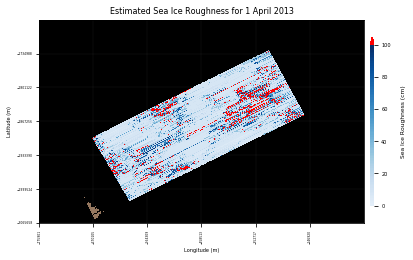

In [61]:
saved_dir = '/Users/ehsanmos/Documents/RnD/MISR_lab/img_dir.nosync'

(fig, ax) = plt.subplots()  # returns one figure==canvas and we can have multiple subplots==axes; has more features than plt.subplot(); figure != plot = image; e.g: fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 5.4))

print(type(fig))
print(type(ax))

img1 = ax.imshow(roughness, cmap=SIR_colormap, origin='lower' , interpolation='none', extent=plot_extent, norm=None, vmin=0.0, vmax=100);  # normalization=None == not linear scale data into [lowest=0,highest=1] & we pick the data range to plot [0,100]
img2 = ax.imshow(land, cmap= land_color, origin='lower', interpolation='none', extent=plot_extent)
img3 = ax.imshow(nodata, cmap=nodata_color, origin='lower', interpolation='none', extent=plot_extent);

#~ colorbar
cmap_title = 'Sea Ice Roughness (cm)'
cbar = fig.colorbar(img1, extend='max', aspect=40, fraction=0.012, pad=0.02);  # extend shows the range that goes beyond max limit on plot
cbar.set_label(cmap_title, rotation=90, labelpad=10, fontsize=6);
cbar.ax.tick_params(labelsize=5)
cbar.outline.set_visible(False)

# plt.title('Sea Ice Roughness over the Arctic'); 
ax.set_title('Estimated Sea Ice Roughness for ' + plot_date, fontsize=8);

#~ axis
# ax = plt.gca();  # get-current-axis
ax.ticklabel_format(useOffset=False, style='plain', size=10); # do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90); # rotate x tick labels 90 degrees

#~ axis limits
xstart, xend = ax.get_xlim()
xstepsize = abs(xend-xstart)/6
ax.xaxis.set_ticks(np.arange(xstart, xend, xstepsize))

# plt.xlim(xmin=0)


ystart, yend = ax.get_ylim()
ystepsize = abs(yend-ystart)/6
ax.yaxis.set_ticks(np.arange(ystart, yend, ystepsize))

#~ axis font size
plt.xticks(fontsize=3)
plt.yticks(fontsize=3)

#~ grid
ax.grid(True, which='both', axis='both', color='white', linewidth=0.05)

#~ x and y labels
plt.xlabel('Longitude (m)', fontsize=5)
plt.ylabel('Latitude (m)', fontsize=5)

#~ path to save directory
saved_img_fullpath = os.path.join(saved_dir, saved_img_name)
print(saved_img_fullpath)

print('-> START saving image on disc!')
plt.savefig(saved_img_fullpath, bbox_inches='tight', pad_inches=0.2, dpi=600)
print('-> FINISHED saving image on disc!')

plt.show()     # should come after plt.savefig()

plt.close()    # close the figure window; plt.close(fig) if we created by:  fig, ax = plt.subplots()


# inspired by: 
# https://www.neonscience.org/resources/learning-hub/tutorials/mask-raster-py
# https://www.neonscience.org/resources/learning-hub/tutorials/neon-hsi-aop-functions-tiles-py


In [57]:
dataset = None